In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
#import regionmask
from ComputeLCLpressure_function import ComputeLCLpressure

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in CAM5+CLM5 data

In [13]:
# Set directories for raw data 
cesmDir = '/glade/work/mdfowler/data/CLM5wCAM5_highOutput/'

fileCLM = cesmDir+'f.e21.FHIST.f09_f09_mg17.CLM5wCAM5phys-subDailyOutput.001.clm2.h1.1979-89_10cmSoilWater.nc'
fileCAM = cesmDir+'f.e21.FHIST.f09_f09_mg17.CLM5wCAM5phys-subDailyOutput.001.cam.h1.1979-89_CIvariables.nc'

camDS = xr.open_dataset(fileCAM, decode_times=False)
print('Finished reading in CAM file')
clmDS = xr.open_dataset(fileCLM, decode_times=False)
print('Finished reading in CLM file')


Finished reading in CAM file
Finished reading in CLM file


In [6]:
# Get lat and lon 
lat = camDS.lat.values
lon = camDS.lon.values


### Use Brian's code to adjust time to be midpoint

In [8]:
def cesm_correct_time_CAM(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds


In [25]:
# Use this for CLM times too 
correct_time_values = camDS['time']
clmDS = clmDS.assign_coords({"time": correct_time_values})
clmDS = xr.decode_cf(clmDS) 


### Average everything up to daily 

In [32]:
camDS_daily = camDS.resample(time='1D').mean()
clmDS_daily = clmDS.resample(time='1D').mean()


In [33]:
camDS_daily['time'].values[0:10]


array([cftime.DatetimeNoLeap(1979-06-01 00:00:00),
       cftime.DatetimeNoLeap(1979-06-02 00:00:00),
       cftime.DatetimeNoLeap(1979-06-03 00:00:00),
       cftime.DatetimeNoLeap(1979-06-04 00:00:00),
       cftime.DatetimeNoLeap(1979-06-05 00:00:00),
       cftime.DatetimeNoLeap(1979-06-06 00:00:00),
       cftime.DatetimeNoLeap(1979-06-07 00:00:00),
       cftime.DatetimeNoLeap(1979-06-08 00:00:00),
       cftime.DatetimeNoLeap(1979-06-09 00:00:00),
       cftime.DatetimeNoLeap(1979-06-10 00:00:00)], dtype=object)

In [34]:
# To be able to easily access years, months, days - use Pandas 
dates    = pd.DatetimeIndex(camDS_daily['time'].values)


TypeError: <class 'cftime._cftime.DatetimeNoLeap'> is not convertible to datetime

### Compute LCL pressure 

In [36]:
nT = len(camDS_daily['time'].values)
print('Number of times: ', nT)


Number of times:  3833


In [37]:
fileOutName = '/glade/work/mdfowler/scripts/Coupling_CAM6CLM5/processed_data/LCL-pressure-HeightAboveGround_CAM5wCLM5.p'

# ------- Start computing ----------

# Convert temperature to ˚C 
T_degC = camDS_daily['TREFHT'].values - 273.15

# Get RH as fraction, not %
RH_frac = camDS_daily['RHREFHT'].values / 100.0 

# Convert surface pressure to hPa 
PS_hPa = camDS_daily['PS'].values / 100.0

# Compute dew point and P_LCL 
Td   = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in Kelvin
Plcl = np.full([np.shape(T_degC)[0], len(lat), len(lon)], np.nan)  #Saved to be in hPa 

# Define constants for dew point calculation
c1 = 610.94   # [Pa]
a1 = 7.625
b1 = 243.04   # [degC]

for iT in range(np.shape(T_degC)[0]):

    # Compute dewpoint temperature:
    numerator   = b1 * (np.log(RH_frac[iT,:,:]) + ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) )
    denominator = a1 - np.log(RH_frac[iT,:,:]) - ( (a1*T_degC[iT,:,:])/(b1 + T_degC[iT,:,:]) ) 

    Td[iT,:,:] = (numerator/denominator) + 273.15   #Convert to K here too 

    # Compute pressure level of LCL:
    inner        = ((camDS_daily['TREFHT'].values[iT,:,:] - Td[iT,:,:]) / 223.15) + 1  # Part inside ()
#    Plcl[iT,:,:] = PS_hPa[iT,:,:]*(inner**(-3.5))
    Plcl[iT,:,:] = PS_hPa[iT,:,:] - (PS_hPa[iT,:,:]*(inner**(-3.5)))    # Want to get distance above sfc in mb 

    if (iT % round(nT/10))==0: 
        print('Done with ', (iT/nT)*100, ' % of days')

# Add check to set Plcl to zero if it's negative (below the surface pressure)
Plcl[Plcl<0] = np.nan

# Looking at Betts (2004), it looks like Plcl is actually the mean depth to cloud base; not just its pressure level
#   So to get the depth of the layer from sfc to cloud bottom in hPa, need to take Plcl - PS. 
# Plcl = PS_hPa - Plcl

# ------- Save out data --------

# Save the array with residaul S.T. and S.M. z-scores in it 

pickle.dump( Plcl, open( fileOutName, "wb" ), protocol=4 )

print('Finished computing LCL-pressure level successfully and saved pickle file:') 



Done with  0.0  % of days
Done with  9.992173232454995  % of days
Done with  19.98434646490999  % of days
Done with  29.97651969736499  % of days
Done with  39.96869292981998  % of days
Done with  49.96086616227498  % of days
Done with  59.95303939472998  % of days
Done with  69.94521262718497  % of days
Done with  79.93738585963996  % of days
Done with  89.92955909209496  % of days
Done with  99.92173232454996  % of days
Finished computing LCL-pressure level successfully and saved pickle file:


In [38]:
# Read in land mask 
filePath = '/glade/work/mdfowler/data/CESM2_clm4.5/f.e20.FHIST.f09_f09.cesm2_1_clm4.5.001.clm2.h1.1976-01-01-00000.nc'
exDF     = xr.open_dataset(filePath,decode_times=False)

landMask              = exDF.landmask.values.astype(float)
landMask[landMask==0] = np.nan


## Sanity check: do variables look okay? 

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


Text(0.5, 1.0, '10-cm SM (time mean, 1980-2006)')

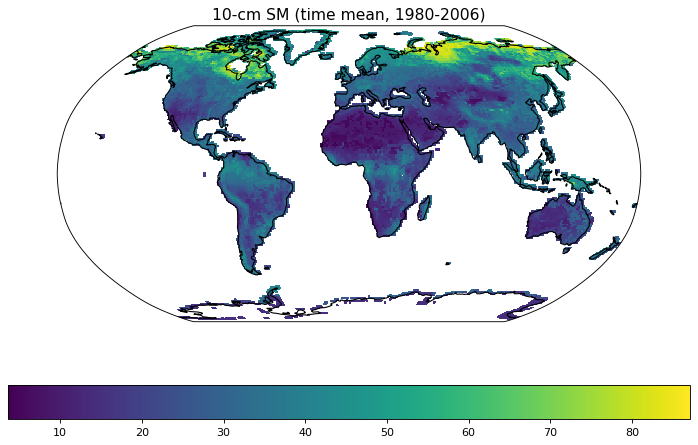

In [39]:
# How about SM? 

fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
SMavg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(clmDS_daily.SOILWATER_10CM.values,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,
                             SMavg_cyclic,
                             transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot,orientation='horizontal')
ax.set_title('10-cm SM (time mean)', fontsize=14)


Text(0.5, 1.0, 'Pressure Level of LCL (time average)')

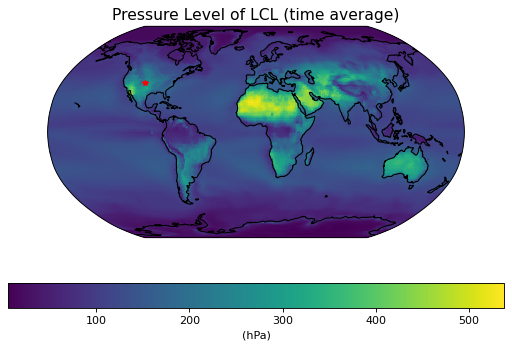

In [40]:
# Map out average pressure level of the LCL (in terms of height above sfc)

fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
Plcl_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(np.nanmean(Plcl,0)), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,Plcl_cyclic,
                             transform=ccrs.PlateCarree())
ax.plot(lon_cyclic[206],lat[135],'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(hPa)',orientation='horizontal')
ax.set_title('Pressure Level of LCL (time average)', fontsize=14)



In [ ]:
# Plot a timeseries of variables 

fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

ax1.plot(dates, camDS_daily.SHFLX.values[:,135,206],'k-')
ax1.set_ylabel('SHFLX (W/m2)')
ax1.set_xlabel('Time')
ax1.legend(['SHF'],loc='upper left',fontsize=12)
ax1.set_title('Sanity check: SHF & Plcl [midwest point]', fontsize=14)
ax1.axhline(0,color='gray')

ax2 = ax1.twinx()
ax2.plot(dates, Plcl[:,135,206], 'r-')
ax2.set_ylabel('Plcl height above sfc (hPa)')
ax2.legend(['Plcl'], loc='upper right',fontsize=12)

ax1.set_xlim([datetime.date(1990,6,1), datetime.date(1990,7,1)])


## Save CI variables out to pickle files

In [41]:
fileOut_CIvars = '/glade/work/mdfowler/data/CLM5wCAM5_highOutput/CLM5wCAM5_CI_Variables-SHFLX_LHFLX_SM_Plcl.p'

# Make one big xr.Dataset containing all the information we need  
dFull = camDS_daily
dFull['soilM_10'] = (('time','lat','lon'), clmDS_daily.SOILWATER_10CM.values)
dFull['Plcl'] = (('time','lat','lon'), Plcl)

dFull.to_netcdf(path=fileOut_CIvars)


In [42]:
testDS = xr.open_dataset(fileOut_CIvars, decode_times=True)


In [43]:
testDS

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 3833)
Coordinates:
  * time      (time) object 1979-06-01 00:00:00 ... 1989-11-30 00:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    LHFLX     (time, lat, lon) float32 ...
    PS        (time, lat, lon) float32 ...
    RHREFHT   (time, lat, lon) float32 ...
    SHFLX     (time, lat, lon) float32 ...
    TREFHT    (time, lat, lon) float32 ...
    soilM_10  (time, lat, lon) float32 ...
    Plcl      (time, lat, lon) float64 ...

# Now get CI itself (based on saved file above, so doing this locally) 

In [5]:
fileName = '/Users/mdfowler/Documents/Analysis/Coupling_initial/data/day/CLM5wCAM5_CI_Variables-SHFLX_LHFLX_SM_Plcl.p'

varsDS         = xr.open_dataset(fileName, decode_times=True)
varsDS['time'] = varsDS.indexes['time'].to_datetimeindex()


<ipython-input-5-deef5cccf824>:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  varsDS['time'] = varsDS.indexes['time'].to_datetimeindex()


In [8]:
lon = varsDS.lon.values
lat = varsDS.lat.values

In [3]:
varsDS

<xarray.Dataset>
Dimensions:   (lat: 192, lon: 288, time: 3833)
Coordinates:
  * time      (time) object 1979-06-01 00:00:00 ... 1989-11-30 00:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    LHFLX     (time, lat, lon) float32 ...
    PS        (time, lat, lon) float32 ...
    RHREFHT   (time, lat, lon) float32 ...
    SHFLX     (time, lat, lon) float32 ...
    TREFHT    (time, lat, lon) float32 ...
    soilM_10  (time, lat, lon) float32 ...
    Plcl      (time, lat, lon) float64 ...

In [6]:
terra_coupling = cm.metrics.CouplingIndex()
terra_coupling = terra_coupling.compute(varsDS, xname='soilM_10',yname='LHFLX',averaging='season')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Terrestrial Coupling Index (10cm SM and LHFLX) [DJF]')

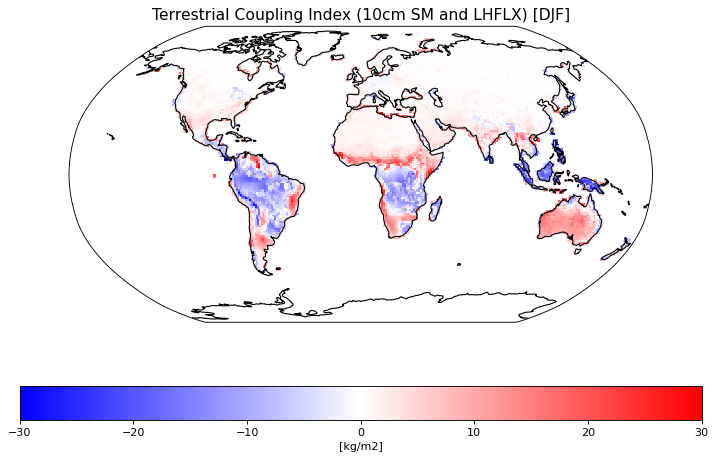

In [9]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
terraCoupl_DJF, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(terra_coupling.soilM_10_LHFLX_CI[0,:,:]), lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,terraCoupl_DJF,vmin=-30,vmax=30,cmap='bwr',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[kg/m2]',orientation='horizontal')
ax.set_title('Terrestrial Coupling Index (10cm SM and LHFLX) ['+np.asarray(terra_coupling.season)[0]+']', fontsize=14)


In [10]:
# Save to netCDF file
terra_coupling.to_netcdf('/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_lhf_vs_soilm_CAM5-CLM5.nc')


In [12]:
# --- Compute coupling index between soil moisture and sensible heat flux (terrestrial leg) --- # 

# Compute coupling index 
terraLeg_coupling = cm.metrics.CouplingIndex()
terraLeg_coupling = terraLeg_coupling.compute(varsDS, xname='soilM_10',yname='SHFLX',averaging='season')

# Save to netCDF file
terraLeg_coupling.to_netcdf('/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/TerraLeg_coupling_shf_vs_soilm_CAM5-CLM5.nc')


/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [13]:
# --- Compute coupling index between sensible heat flux and pressure level of LCL (atmospheric leg) --- #

# Compute coupling index 
atmoLeg_coupling = cm.metrics.CouplingIndex()
atmoLeg_coupling = atmoLeg_coupling.compute(varsDS, xname='SHFLX',yname='Plcl',averaging='season')

# Save to netCDF file 
atmoLeg_coupling.to_netcdf('/Users/mdfowler/Documents/Analysis/Coupling_initial/Coupling_CAM6CLM5/processed_data/AtmoLeg_coupling_Plcl_vs_shf_CAM5-CLM5.nc')



/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/mdfowler/opt/anaconda3/envs/newBase/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
